In [260]:
%load_ext nb_black
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("fast")
import numpy as np
from IPython.display import set_matplotlib_formats, SVG

set_matplotlib_formats("svg")
import msprime as msp

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

# Lecture 7
## Natural selection

So far we have studied neutral, haploid, evolution, where no gene type has a fitness advantage over any other gene type. This week we will relax those assumptions, by studying various types of natural selection.

Broadly speaking, there natural selection can be grouped into one of three different types:
- Directional selection: some genes have a fitness (dis)advantage relative to other genes.
- Balancing selection: Heterozygotes have a fitness advantage relative to homozygotes.
- Background selection: The action of natural selection to constantly purify the population of deleterious alleles.

## Directional selection
We start by assuming that there are two gene types, $A$ and $a$, and that $a$ has a fitness $1-s$ relative to $A$. This means that, when reproduction occurs, the $a$ genes are $1-s$ less likely to pass on genetic material. (Note that $s$ can be negative, in which case they $a$ becomes more fit than $A$.)

### Moran model
In analyzing the effects of selection, it turns out to be slightly easier to work with a different, but equivalent, model of evolution, called the *Moran model*.

In the Moran model, we again have a fixed population of size $2N$ evolving forwards in time. However, unlike the W-F model, reproduction no longer happens in discrete generations. Instead, each gene lives for an $\mathrm{Exp}(1)$-distributed amount of time, then dies and is replaced with another individual sampled from the population. (It is possible that the individual replaces themself.)

Here is a simulation/visualization of this process:

In [261]:
def moran(T, N):
    fig, ax = plt.subplots(figsize=(8, 5))
    # visualize the moran process for T units of time
    t = 0
    while t < T:
        t += np.random.exponential(scale=1 / (2 * N))
        i, j = np.random.choice(2 * N, size=2, replace=False)
        plt.arrow(
            t,
            i,
            0,
            j - i,
            head_width=0.01,
            head_length=0.5,
            fc="k",
            ec="k",
            length_includes_head=True,
            color="tab:blue",
        )
        plt.scatter(t, j, color="tab:blue")
    plt.ylim(-1, 2 * N)
    plt.hlines(np.arange(2 * N + 1), 0, t, color="grey")
    plt.xlabel(r"Time $\longrightarrow$")

<IPython.core.display.Javascript object>

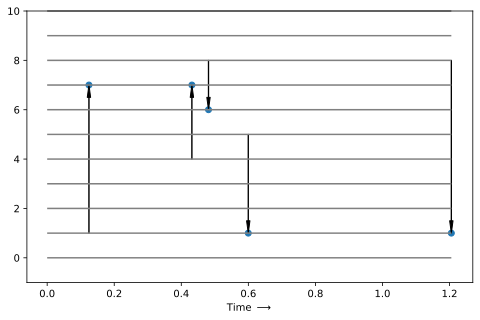

<IPython.core.display.Javascript object>

In [263]:
moran(T=1, N=5)

Although the Moran model outwardly looks rather different from the W-F model, it in fact has the same genealogical structure.

**Theorem**. If time is measured in units of $N$, the genealogy of a sample of size $n$ converges to Kingman's coalescent.

*Proof*. Consider sampling $n$ lineages in the Moran model. The probability that the most recent event involved one of these lineages copying onto another of them $n(n-1)/2N$. Thus, if time is measured in units of $N$ (*not* $2N$) generations, then the rate of coalescence per unit time is $\binom{n}{2}$.

### Moran model with two alleles
To make the dynamics of the Moran process a bit clearer, we can add different types of alleles to our model, say $A$ and $a$. The lineages carrying the $A$ allele are now colored in <span style="color:red;">red</span>.

In [264]:
def moran_with_types(T, N, types=None):
    fig, ax = plt.subplots(figsize=(8, 5))
    # visualize the moran process for T units of time
    t = 0
    c = np.array(["black", "tab:red"])
    if types is None:
        types = np.random.randint(2, size=2 * N)
    A = np.arange(2 * N)
    while t < T:
        dt = np.random.exponential(scale=1 / (2 * N))
        plt.hlines(A, t, t + dt, colors=c[types])
        t += dt
        i, j = np.random.choice(2 * N, size=2, replace=False)
        types[j] = types[i]
        plt.arrow(
            t,
            i,
            0,
            j - i,
            head_width=0.01,
            head_length=0.5,
            length_includes_head=True,
            color=c[types[j]],
        )
        plt.scatter(t, j, color=c[types[j]])
    plt.ylim(-1, 2 * N)
    plt.xlabel(r"Time $\longrightarrow$")
    # plt.xlim(*reversed(plt.xlim()))

<IPython.core.display.Javascript object>

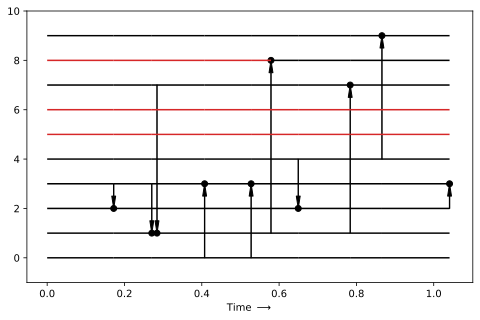

<IPython.core.display.Javascript object>

In [265]:
moran_with_types(T=1, N=5)

### Moran model with selection
To add selection to our model, we assume that when a death takes place, the $A$ genes are more likely to replace the dead lineage. That is, if $X_t$ is the number of $A$ alleles at time $t$, then the rates of transition are
\begin{align}
i &\to i + 1\text{ at rate }\underbrace{(2N-i)}_{\text{an $a$ dies}}\underbrace{(i/2N)}_{\text{an $A$ replaces it}}\\
i &\to i - 1\text{ at rate }\underbrace{i}_{\text{an $A$ dies}}\times \underbrace{(1-s)(2N-i)/2N}_{\text{an $a$ replaces it}}
\end{align}
The quantity $s$ is called the *selection coefficient*. Thus, conditional on the death event occuring, the number of $A$ alleles increases with probability $1/(2-s)$, and decreases otherwise. (Note that $s<0$ is allowed).

In [268]:
def moran_with_sel(T, N, s, types=None, col="black"):
    fig, ax = plt.subplots(figsize=(8, 5))
    # visualize the moran process for T units of time
    t = 0
    c = np.array([col, "tab:red"])
    if types is None:
        types = np.random.randint(2, size=2 * N)
    A = np.arange(2 * N)
    sel = np.array([1 - s, 1.0])
    while t < T:
        dt = np.random.exponential(scale=1 / (2 * N))
        plt.hlines(A, t, t + dt, colors=c[types])
        t += dt
        j = np.random.choice(2 * N)  # chosen to die
        p = sel[types]
        i = np.random.choice(2 * N, p=p / p.sum())  # chosen to replace
        types[j] = types[i]
        plt.arrow(
            t,
            i,
            0,
            j - i,
            head_width=0.01,
            head_length=0.5,
            length_includes_head=True,
            color=c[types[i]],
        )
    plt.ylim(-1, 2 * N)
    plt.xlabel(r"Time $\longrightarrow$")

<IPython.core.display.Javascript object>

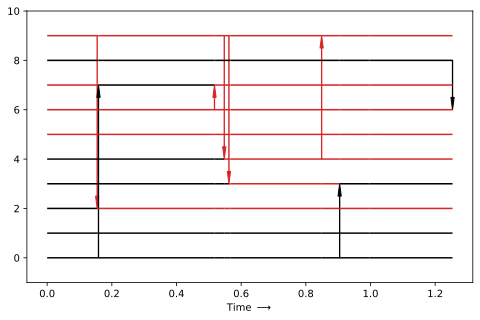

<IPython.core.display.Javascript object>

In [269]:
moran_with_sel(1, 5, 0.5)

**Theorem**. In the Moran model with selection, the probability that an allele with fitness advantage $s$ fixes is $$\frac{1-(1-s)^i}{1-(1-s)^{2N}},$$ where $i$ is the initial frequency.

*Proof*. Let $X_t$ be the number of $A$ alleles at time $t$. Let $u$ be the time of the next replacement event. Then 
\begin{align}
\mathbb{E}\left[(1-s)^{X_u} \mid X_t\right] &= (1-s)^{X_t+1} \frac{1}{2-s} + (1-s)^{X_t-1}\frac{1-s}{2-s} \\
&=(1-s)^{X_t}.
\end{align}
Thus, $(1-s)^{X_t}$ is a martingale, so it has constant expectation. If we again let $\tau$ denote the stopping time when either one of the two alleles fixes, then

$$(1-s)^{2N}\mathbb{P}(X_\tau=2N)=\mathbb{E}(1-s)^{X_\tau}-\mathbb{P}(X_\tau=0)=(1-s)^i-(1-\mathbb{P}(X_\tau=2N)),$$

which can be rearranged to yield the claim.

We can also derive a related result about the amount of time the elapses until fixation.

**Theorem**. Given that the selected allele starts with 1 copy in the population and eventually fixes, the expected amount of time to fixation is $\sim (2/s) \log N$ as $N\to\infty$.

*Proof*. Though not particularly difficult, a rigorous proof is a bit too complicated to do over Zoom, see Durrett pp. 194-197. But a heuristic proof by picture is:

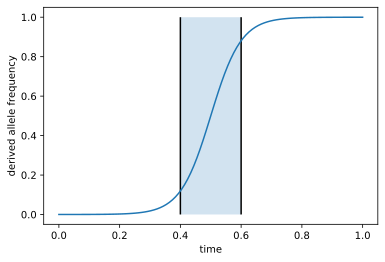

<IPython.core.display.Javascript object>

In [271]:
sel_illustration, ax = plt.subplots()
x = np.linspace(0, 1, 100)
ax.plot(x, 1 / (1 + np.exp(-20 * (x - 0.5))))
ax.set_xlabel("time")
ax.set_ylabel("derived allele frequency")
ax.vlines([0.4, 0.6], 0, 1)
ax.fill_betweenx([0, 1], 0.4, 0.6, alpha=0.2)

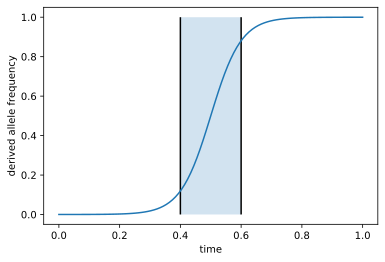

<IPython.core.display.Javascript object>

In [272]:
sel_illustration

The derived allele spends a comparatively long amount of time at low and high frequencies, and less time at intermediate frequencies in the shaded box. By approximating the low and high regimes by a branching process, you can show that the amount of time spent there is $\sim (2/s)\log N$, versus $o(\log N)$ in the middle.

### Effect of directional selection on genealogies

How does natural selection act to shape genealogies? Let's consider what happens when we introduce one copy of strongly selected allele into the W-F model:

In [273]:
## Tracking inheritance
# parents = np.random.choice(2 * N, size=2 * N)
def wf_sel(N, G, s):
    fig, _ = plt.subplots(figsize=(8, 5))
    plt.scatter(*np.mgrid[:G, : 2 * N])
    fitness = np.ones(2 * N)

    ancestral = np.array([False] * 2 * N)
    for g in range(G - 1, -1, -1):
        if g == G // 2:
            fitness[N] = 1 + s
            ancestral[N] = True
        parents = np.sort(
            np.random.choice(2 * N, replace=True, size=2 * N, p=fitness / fitness.sum())
        )
        fitness = fitness[parents]
        ancestral = ancestral[parents]
        new_ancestral = np.array([False] * 2 * N)
        for j, (p, a) in enumerate(zip(parents, ancestral)):
            x = [g - 1, g]
            y = [j, p]
            plt.plot(x, y, color="red" if a else "lightgrey")
            new_ancestral[j] |= ancestral[p]
        ancestral = new_ancestral
    # return fig

<IPython.core.display.Javascript object>

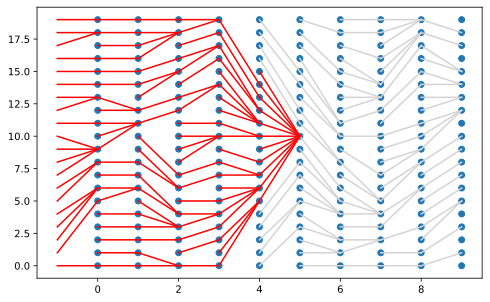

<IPython.core.display.Javascript object>

In [274]:
wf_sel(10, 10, 10.0)

### Confounding with demography
Notice that these genealogies look quite a bit like the following:

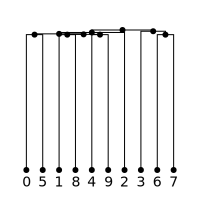

<IPython.core.display.Javascript object>

In [277]:
SVG(
    msp.simulate(
        sample_size=10,
        Ne=100,
        demographic_events=[
            msp.PopulationParametersChange(time=1, initial_size=1 / 100)
        ],
    )
    .first()
    .draw(node_labels={i: i for i in range(10)})
)

In the above example, we simulated under neutrality, but with a population bottleneck. This illustrates the fact that demography and selection are confounded. We will see another example of this shortly.

## Balancing selection
Balancing selection is a different form of natural selection which favors the maintenance of polymorphism in the population. In other words, one type of mutation doesn't necessarily "win out" as in directional selection.

A well-known example of balancing selection in humans is sickle-cell anemia. In the red blood cells of people diagnosed with sickle cell disease, haemoglobin A is replaced with an alternative form known as haemoglobin S. This causes the red cells to have a sickle shape, and leads to anemia, chronic pain, and other symptoms.

Genetically, sickle cell anemia is caused by a mutation of the β-globin gene. The dominant allele is called HbA and the recessive allele HbS. People who have two copies HbS express the sickle-cell trait. However, the heterozygote type HbA/HbS has fewer negative health effects, and in fact confers resistance to malaria.

![malaria vs. HbS](https://upload.wikimedia.org/wikipedia/commons/1/10/Malaria_versus_sickle-cell_trait_distributions.png)

### Effect of balancing selection on genealogies
To study balancing selection is a little trickier, because we must now consider a situation where we each individual has 2 copies of the gene. We will code these copies as $A_1$ and $A_2$. Thus you can either by $A_1A_1$, $A_1A_2$, or $A_2A_2$. 

Let the fitnesses of these be $w_{11}$, $w_{12}$, and $w_{22}$, respectively. If the frequency of $A_1$ is currently $x\in[0,1]$, then in expectation, its frequency in the next generation will be 

$$x'=\frac{w_{11} x^2 + w_{12}x(1-x)}{w_{11}x^2 + w_{12}2x(1-x) + w_{22}(1-x)^2} = \frac{m_{1}}{\bar{w}}.$$

The numerator $m_{1}$ is the "marginal fitness" of $A_1$, and the denominator $\bar{w}$ is the average fitness in the population.

Next we add the possibility of mutation. If $\mu$ is the probability of mutating from $A_1\to A_2$ or back (assumed symmetric), then 

$$x' = (1-\mu) \frac{xm_1}{xm_1 + (1-x)m_2} + \mu \frac{(1-x)m_2}{xm_1 + (1-x)m_2}$$

To understand how balancing selection affects genealogies, we are going to approximate the coalescent under balancing selection by a simpler process. These results are due to Darden, Kaplan and Hudson (1988). See also section 6.2 of Durrett.


Let $Q(t)=(i,j)$ be the number of lineages with $A_1,A_2$ alleles at $t$ generations before the present. Also let $X_t$ be the proportion of $A_1$ alleles in generation $t$, so that the mean fitness is 

$$\bar{w}_t = X_t^2 w_{11} + 2X_t(1-X_t)w_{12} + (1-X_t)^2w_{22}.$$

Similarly, let $m_i(t)$ be the marginal fitness of $A_i$. We further suppose that the whole system is in equilibrium, so that $X_t \approx \bar{x}$ for all $t$. Note that this implies that $m_1(t) \approx m_2(t)$ also.

If $f_{A_i}(A_j,t)$ is the joint probability that a randomly chosen gene in generation $t$ is $A_i$ and has parent $A_j$ in generation $t-1$, then

$$f_{A_1}(A_1,t) = (1-\mu)\frac{m_1(t-1)}{\bar{w}_{t-1}}.$$

This says that the probability that an $A_1$ had a parent who was also an $A_1$ is the probability of sampling an $A_1$ in the preceding generation, times the probability of no mutation. By similar arguments, you can work out the other three cases for $f_{A_i}(A_j,t)$.

Also, define $f(A_i,t) = \sum_{j=1}^2 f_{A_j}(A_i,t)$ to be the probability of sampling an $A_i$ in generation $t$ regardless of the type of its parent.

Now we want to compute $\mathbb{P}(Q(t-1)=(i',j') \mid Q(t)=(i,j))$. As usual, we will assume that the population size is large, and the number of sampled lineages is small, and also that $\mu \ll 1$. This lets us restrict attention to cases where $\max(|i'-i|,|j'-j|)=1$. There are two cases to consider:

### Mutation
This corresponds to e.g. $i'=i+1,j'=j-1$ (the total number of lineages is conserved, and we just changed one type to another.) In other words, an $A_1$ parent gave rise to an $A_2$ child.

The *conditional* probability of an $A_1$ parent given that an $A_2$ was sampled at generation $t$ is 

$$\frac{f_{A_2}(A_1,t)}{f(A_2,t)} = \frac{\mu X_{t-1}m_1(t-1)}{\mu X_{t-1}m_1(t-1) + (1-\mu)(1-X_{t-1})m_2(t-1)}.$$

If we assume that the system is in equilbrium, then the marginal fitnesses of both alleles are the same: $m_1(t)\approx m_2(t)$. So those all cancel out. If we additionally assume that $\mu \ll 1$, then the conditional probability simplifies to 

$$\frac{f_{A_2}(A_1,t)}{f(A_2,t)} \approx \mu \frac{\bar{x}}{1-\bar{x}}=\frac{\beta}{2N} \frac{\bar{x}}{1-\bar{x}}, $$

where we defined $\beta\to 0$ such that $$\lim_{\beta\to0,N\to\infty}\frac{\beta}{2N}=\mu.$$

So we conclude that $$\mathbb{P}(Q(t-1)=(i+1,j-1) \mid Q(t)=(i,j)) \approx j\frac{\beta}{2N} \frac{\bar{x}}{1-\bar{x}}$$.

Similarly, you can show 

$$\mathbb{P}(Q(t-1)=(i-1,j+1) \mid Q(t)=(i,j)) \approx i\frac{\beta}{2N}\mu \frac{1-\bar{x}}{\bar{x}}$$.

### Coalescence
The fraction of genes in generation $t$ contributed by a particular $A_1$ gene in generation $t-1$ equals 

$$\frac{f_{A_1}(A_1,t)}{2NX_{t-1}},$$

i.e. the fraction of $A_1$ genes in $t$ that have an $A_1$ parent, divided by the total number of $A_1$ in the previous generation.

Therefore, the probability that two $A_1$ genes in generation $t$ have the same parent in generation $t-1$ is 

$$2NX_{t-1} \left(\frac{f_{A_1}(A_1,t)}{2NX_{t-1}} \times \frac{1}{f(A_1,t)}\right)^2 = \frac{1}{2NX_{t-1}}\times \left(\frac{f_{A_1}(A_1,t)}{f(A_1,t)}\right)^2 = \frac{1}{2NX_{t-1}}+O\left(\frac{1}{N^2}\right).$$

The last equality follows because $f(A_1,t)$ and $f_{A_1}(A_1,t)$ are both $=X_t+O(1/N)$, so their ratio is $=1+O(1/N)$.

Thus, if there are $i$ copies of $A_1$ in generation $t$, then

$$\mathbb{P}(Q(t-1)=(i-1,j) \mid Q(t)=(i,j)) \approx \binom{i}{2}\frac{1}{2NX_{t-1}}.$$

Similarly,

$$\mathbb{P}(Q(t-1)=(i,j-1) \mid Q(t)=(i,j)) \approx \binom{j}{2}\frac{1}{2N(1-X_{t-1})}.$$

Combining all these computations, and rescaling time in units of $2N$, we obtain a stochastic process $Q(t)$ with $Q(0)=(i_0,j_0)$ and rates of transition
\begin{align}
(i,j)&\to(i+1,j-1):j\beta\frac{\bar{x}}{1-\bar{x}} \\
(i,j)&\to(i-1,j+1):i\beta\frac{\bar{x}}{1-\bar{x}} \\
(i,j)&\to(i,j-1):\frac{\binom{j}{2}}{1-\bar{x}}\\
(i,j)&\to(i-1,j):\frac{\binom{i}{2}}{\bar{x}}
\end{align}

### Migration model
The process shown above is also called a migration or island model. We can simulate it using a neutral coalescent simulator in order to understand how balancing selection acts:

In [278]:
N = 10_000
x_bar = 0.5  # at equilibrium, both A1 and A2 are equally likely
i0 = 5
j0 = 5
beta = 1e-9 * 2 * N
sim = msp.simulate(
    Ne=N,
    population_configurations=[
        msp.PopulationConfiguration(sample_size=i0, initial_size=N * x_bar),
        msp.PopulationConfiguration(sample_size=j0, initial_size=N * (1 - x_bar)),
    ],
    migration_matrix=(
        [
            [0, beta * x_bar / (1 - x_bar)],  # 1 -> 2
            [beta * (1 - x_bar) / x_bar, 0],  # 2 -> 1
        ]
    ),
)

<IPython.core.display.Javascript object>

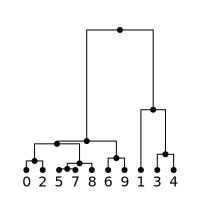

<IPython.core.display.Javascript object>

In [279]:
SVG(sim.first().draw(node_labels={i: i for i in range(i0 + j0)}))